# Prophet Model
By Samuel Khoo

For this project, I aim to follow the intended approach of the Prophet model - the analyst-in-the-loop modeling approach. 

Prophet is a modular regression model with interpretable parameters that can be intuitively adjusted by analysts with domain knowledge about the time series. This approach attempts to blend the advantages of statistical and judgement forecasts by codifying the human domain knowledge in an improved model after some iteration. This allows analysts to apply judgement to forecasts through a small set of intuitive parameters and options, while retaining the ability to fall back on fully automated statistical forecasting when necessary.

Most financial analysts have extensive domain knowledge about the product they are in charge of, but have limited statistical knowledge. On the other hand, broad statistical forecasts do not account for such domain knowledge. Hence, I aim to evaluate if, in the algo-trading context, will analyst-in-the-loop modeling approach would be able to improve returns.

As such, the structure of the notebook is rather different from that of a normal ML project notebook, which showcases only the final version of the model. Instead, I will run through the different iterations which I hope will simulate the thought process of an analyst.

![image.png](https://miro.medium.com/max/3064/1*V6BphWM72PzQ2cLbiIzLwQ.png)

### Table of Contents
1. Exploratory Data Analysis
2. Iteration 1: Using only the time series
3. Iteration 2: Adding Volume as an additional regressor
4. Iteration 3: Adding 3-day Moving Average as an additional regressor

### Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Exploratory Data Analysis

In [4]:
df = pd.read_csv('AAPL (2).csv') #Read the data in
df.Date = pd.to_datetime(df.Date, format='%d/%m/%Y') #Set the date column to datetime
df.set_index('Date', inplace=True) #Set the index to the date column
df = df.rename(columns = {'Adj Close':'Adj_Close'})
df.head(20) #Observe a few rows of data

,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2015-09-01,110.150002,111.879997,107.360001,107.720001,100.533249,76845900
2015-09-02,110.230003,112.339996,109.129997,112.339996,104.845024,61888800
2015-09-03,112.489998,112.779999,110.040001,110.370003,103.006447,53233900
2015-09-04,108.970001,110.449997,108.510002,109.269997,101.979836,49996300
2015-09-08,111.750000,112.559998,110.320000,112.309998,104.817017,54843600
2015-09-09,113.760002,114.019997,109.769997,110.150002,102.801125,85010800
2015-09-10,110.269997,113.279999,109.900002,112.570000,105.059677,62892800
2015-09-11,111.790001,114.209999,111.760002,114.209999,106.590263,49915500
2015-09-14,116.580002,116.889999,114.860001,115.309998,107.616867,58363400


### Data Visualisation

In this section, I graph the adjusted close price time series against the volume to determine any seasonality or holidays that may be useful when fine tuning the Prophet model.

Text(0, 0.5, 'Volume')

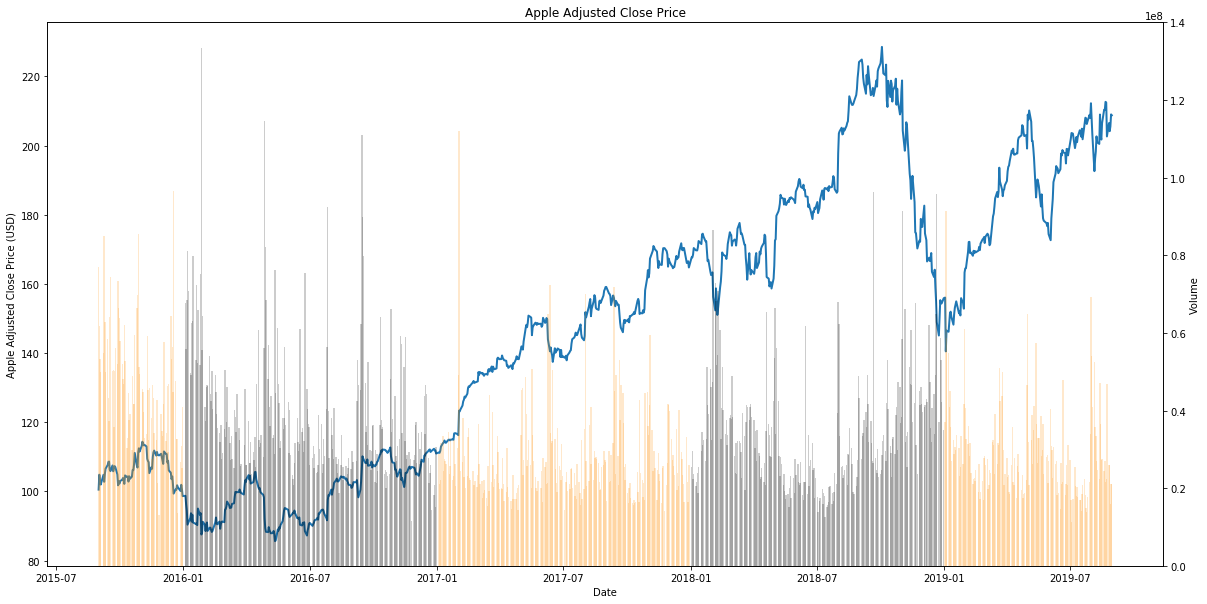

In [5]:
# Split the dataset into the different years
year_2015 = df[(df.index >= '2015-01-01') & (df.index < '2016-01-01')]
year_2016 = df[(df.index >= '2016-01-01') & (df.index < '2017-01-01')]
year_2017 = df[(df.index >= '2017-01-01') & (df.index < '2018-01-01')]
year_2018 = df[(df.index >= '2018-01-01') & (df.index < '2019-01-01')]
year_2019 = df[df.index >= '2019-01-01']

# Build the plot
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()  # set up the 2nd axis
ax1.plot(df.Adj_Close, linewidth=2) #plot the Adjusted Close Price on axis 1

# Plot the yearly data as bar plots and changes the color for each year
ax2.bar(year_2015.index, year_2015.Volume,width=2, alpha=0.2, color='darkorange')
ax2.bar(year_2016.index, year_2016.Volume,width=2, alpha=0.2, color='black')
ax2.bar(year_2017.index, year_2017.Volume,width=2, alpha=0.2, color='darkorange')
ax2.bar(year_2018.index, year_2018.Volume,width=2, alpha=0.2, color='black')
ax2.bar(year_2019.index, year_2019.Volume,width=2, alpha=0.2, color='darkorange')
 
ax2.grid(b=False) # turn off grid 2

# Label the graph
ax1.set_title('Apple Adjusted Close Price')
ax1.set_ylabel('Apple Adjusted Close Price (USD)')
ax1.set_xlabel('Date')
ax2.set_ylabel('Volume')

There seems to be a correlation between price fluctuations and volume. When the price fluctuates significantly, there is a spike in volume. We will explore if volume is a good indicator of price changes in one of the iterations below.

## Iteration Evaluation

To compare each iteration fairly, I have standardised the following:
- The model will predict 3 days in advance. This is for practicality as analysts would often have to go through a number of operational processes before executing the trade.
- The iterations will be evaluated based on their R-squared value, Mean Squared Error (MSE) and Mean Absolute Error (MAE).

The Train-Test split is as follows:

- Training Set: 01/09/2015 to 31/08/2018
- Test Set: 01/09/2018 to 30/08/2019 (31/08/2019 is a Saturday)
- There are some missing dates due to weekends and public holidays

## Iteration 1: Using only the time series

In this iteration, I will test the Prophet model straight out of the box. The baseline Prophet model only takes in the time series data which we are trying to predict. Hence, for this iteration, no additional regressors will be supplied.

### Data Preprocessing

In [50]:
# Keep only required variables
y = df[['Adj_Close']]

# Get Training set
y_train = y[y.index <= '2018-08-31']

#Get Test set
y_test = y[y.index > '2018-08-31']

# Preview training set
y_train.head()

,Adj_Close
Date,
2015-09-01,100.533249
2015-09-02,104.845024
2015-09-03,103.006447
2015-09-04,101.979836
2015-09-08,104.817017


As the model aims to predict with a 3 day lead, I will shift the values down by 3 days. At the same time, I will be reformatting the dataframe for the Prophet model.

In [51]:
y_train = y_train.reset_index()
y_train = y_train.rename(columns={'Date':'ds', 'Adj_Close':'y'}) # rename the columns in the Prophet format
y_train['y'] = y_train['y'].shift(3) # push the training set values down by 3 days
y_train = y_train[y_train['ds'] > '2015-09-03'] # remove the NaN values caused by the shift
y_train = y_train.reset_index(drop=True)
y_train.head()

,ds,y
0,2015-09-04,100.533249
1,2015-09-08,104.845024
2,2015-09-09,103.006447
3,2015-09-10,101.979836
4,2015-09-11,104.817017


In [52]:
# create the future dataframe for prophet to predict on
y_test = y_test.reset_index()
y_test = y_test.rename(columns={'Date':'ds', 'Adj_Close':'y'})
future = y_test[['ds']]
future.head()

,ds
0,2018-09-04
1,2018-09-05
2,2018-09-06
3,2018-09-07
4,2018-09-10


### Training and testing the model

In [54]:
m = Prophet() # Initializing the model
m.fit(y_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [55]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
245,2019-08-26,272.899248,221.432576,320.878018
246,2019-08-27,272.889856,221.962099,321.724741
247,2019-08-28,273.100847,220.483696,322.449391
248,2019-08-29,273.470017,220.027970,321.661729
249,2019-08-30,273.758733,222.622741,322.364103


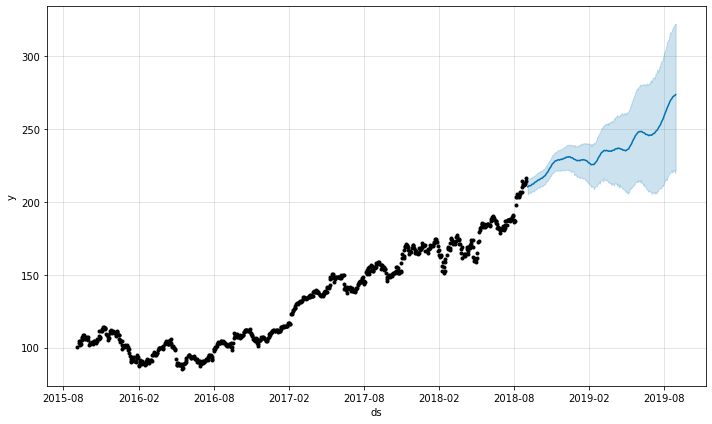

In [56]:
fig1 = m.plot(forecast)

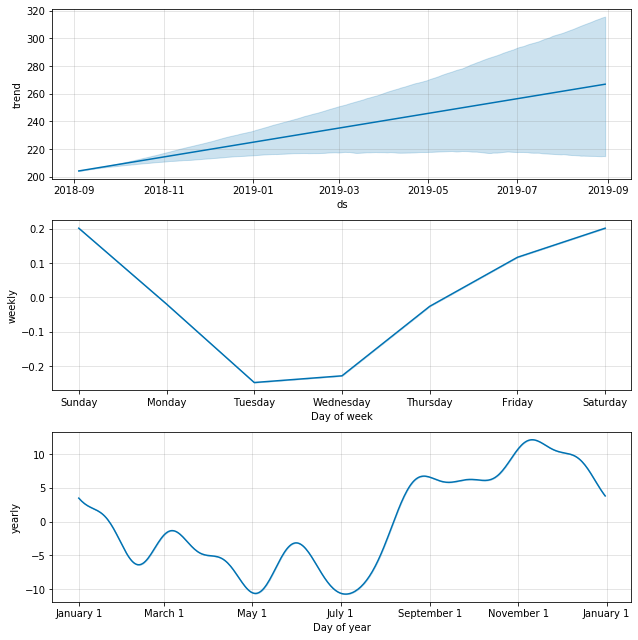

In [57]:
fig2 = m.plot_components(forecast)

### Evaluating the model

In [58]:
# Append the forecasted data to the test data
y_test['yhat'] = forecast['yhat']
y_test.tail()

In [65]:
# Calculate R-squared value
r2_score(y_test['y'], y_test['yhat'])

-5.002520621551185

In [67]:
# Calculate MSE
mean_squared_error(y_test['y'], y_test['yhat'])

2644.0917152007137

In [70]:
# Calculate MAE
mean_absolute_error(y_test['y'], y_test['yhat'])

46.32917374757597

### Iteration 1 Conclusion:

From this iteration, we see that using past time series data alone is insufficient. The model failed to predict the huge drop in the second half of 2018. All three indicators (R-squared, MSE, MAE) performed very badly.

## Iteration 2: Adding Volume as an additional regressor

In this iteration, we will include volume as an additional regressor. From our exploratory data analysis, there seem to be a correlation between volume and price fluctuation. Hence, we would like to test if volume would be a good input for predicting the adjusted close price.

### Data Preprocessing

In [82]:
# Keep only required variables
y2 = df[['Adj_Close', 'Volume']]

# Get Training set
y2_train = y2[y2.index <= '2018-08-31']

#Get Test set
y2_test = y2[y2.index > '2018-08-31']

# Preview training set
y2_train.head()

,Adj_Close,Volume
Date,,
2015-09-01,100.533249,76845900
2015-09-02,104.845024,61888800
2015-09-03,103.006447,53233900
2015-09-04,101.979836,49996300
2015-09-08,104.817017,54843600


Following the previous iteration, I will shift the values down and reformat the dataframe.

In [83]:
y2_train = y2_train.reset_index()
y2_train = y2_train.rename(columns={'Date':'ds', 'Adj_Close':'y'}) # rename the columns in the Prophet format
y2_train['y'] = y2_train['y'].shift(3) # push the training set values down by 3 days
y2_train = y2_train[y2_train['ds'] > '2015-09-03'] # remove the NaN values caused by the shift
y2_train = y2_train.reset_index(drop=True)
y2_train.head()

,ds,y,Volume
0,2015-09-04,100.533249,49996300
1,2015-09-08,104.845024,54843600
2,2015-09-09,103.006447,85010800
3,2015-09-10,101.979836,62892800
4,2015-09-11,104.817017,49915500


In [84]:
# create the future dataframe for prophet to predict on
y2_test = y2_test.reset_index()
y2_test = y2_test.rename(columns={'Date':'ds', 'Adj_Close':'y'})
future2 = y2_test[['ds', 'Volume']]
future2.head()

,ds,Volume
0,2018-09-04,27390100
1,2018-09-05,33333000
2,2018-09-06,34290000
3,2018-09-07,37619800
4,2018-09-10,39516500


### Training and testing the model

In [85]:
m2 = Prophet() # Initialising the model
m2.add_regressor('Volume') # Add the regressor
m2.fit(y2_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [86]:
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
245,2019-08-26,272.686834,221.612879,318.633637
246,2019-08-27,272.729284,222.591434,318.837954
247,2019-08-28,273.434952,223.106237,322.260519
248,2019-08-29,273.548729,223.479990,320.703512
249,2019-08-30,273.961136,221.733032,323.114019


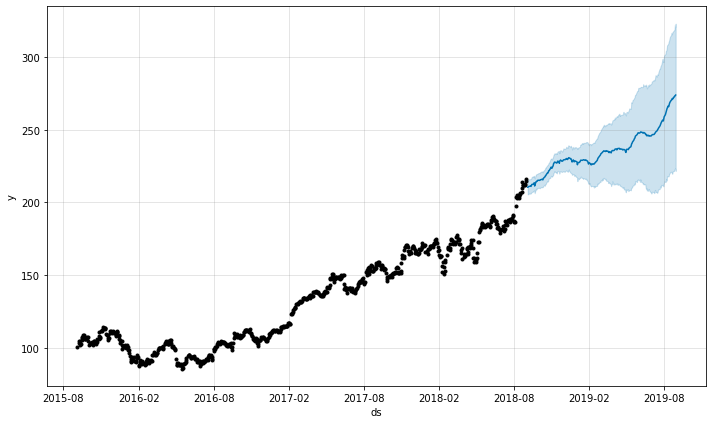

In [87]:
fig1 = m2.plot(forecast2)

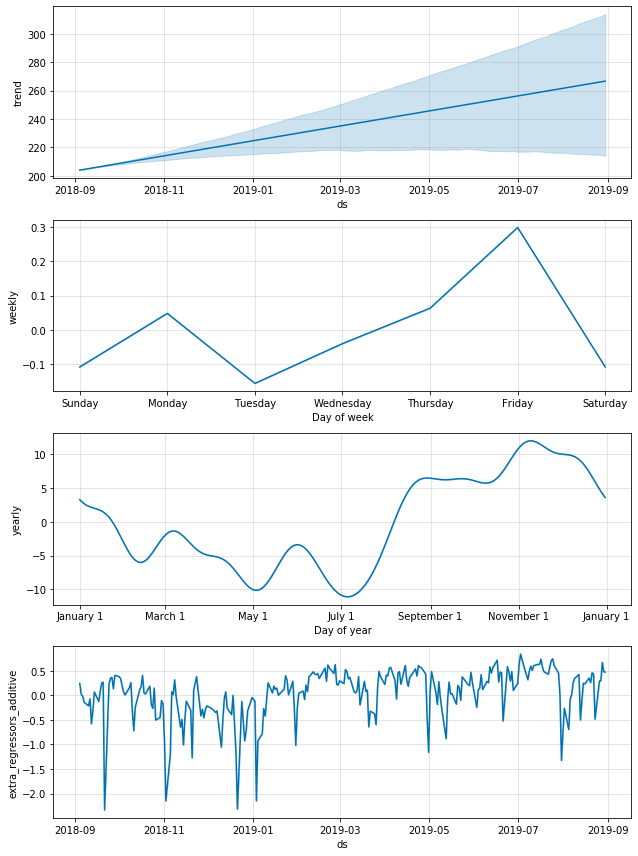

In [88]:
fig2 = m2.plot_components(forecast2)

### Evaluating the model

In [89]:
# Append the forecasted data to the test data
y2_test['yhat'] = forecast2['yhat']
y2_test.tail()

,ds,y,Volume,yhat
245,2019-08-26,206.490005,26043600,272.686834
246,2019-08-27,204.160004,25873300,272.729284
247,2019-08-28,205.529999,15938800,273.434952
248,2019-08-29,209.009995,20990500,273.548729
249,2019-08-30,208.740005,21143400,273.961136


In [90]:
# Calculate R-squared value
r2_score(y2_test['y'], y2_test['yhat'])

-4.981603063557832

In [91]:
# Calculate MSE
mean_squared_error(y2_test['y'], y2_test['yhat'])

2634.8775957866324

In [92]:
# Calculate MAE
mean_absolute_error(y2_test['y'], y2_test['yhat'])

46.25164350764241


### Iteration 2 Conclusion:

Although volume did help improve the indicators slighlty, the general trend of the prediction is still completely off. Hence, using raw time series data does not seem effective for the Prophet model.

## Iteration 3: Adding 3-day Moving Average as an additional regressor

In this iteration, we will include 3 day MA as an additional regressor. The Prophet model allows for the analyst to combine his/her domain knowledge in the product with the statistical prowess of the model. The 3-day Moving Average is a very familiar indicator to most analysts and we would like to see its effect on the model's accuracy.

### Data Preprocessing

In [94]:
# Calculate the 3-day Moving Average
rolling_mean_3 = df.Adj_Close.rolling(window=3).mean()

# Adding the indicator to the dataset
df2 = df.copy()
df2['3_day_MA'] = rolling_mean_3.values
df2.head()

,Open,High,Low,Close,Adj_Close,Volume,3_day_MA
Date,,,,,,,
2015-09-01,110.150002,111.879997,107.360001,107.720001,100.533249,76845900,NaN
2015-09-02,110.230003,112.339996,109.129997,112.339996,104.845024,61888800,NaN
2015-09-03,112.489998,112.779999,110.040001,110.370003,103.006447,53233900,102.794907
2015-09-04,108.970001,110.449997,108.510002,109.269997,101.979836,49996300,103.277102
2015-09-08,111.750000,112.559998,110.320000,112.309998,104.817017,54843600,103.267767


In [99]:
# Keep only required variables
y3 = df2[['Adj_Close', '3_day_MA']]

# Get Training set
y3_train = y3[(y3.index <= '2018-08-31') & ('2015-09-03' <= y2.index)] # to remove NaN values

#Get Test set
y3_test = y3[y3.index > '2018-08-31']

# Preview training set
y3_train.head()

,Adj_Close,3_day_MA
Date,,
2015-09-03,103.006447,102.794907
2015-09-04,101.979836,103.277102
2015-09-08,104.817017,103.267767
2015-09-09,102.801125,103.199326
2015-09-10,105.059677,104.225940


similar to prev iteration...
Since we want to predict w 3 days lead, we will shift the values down. meanwhile getting the format right for prophet

In [100]:
y3_train = y3_train.reset_index()
y3_train = y3_train.rename(columns={'Date':'ds', 'Adj_Close':'y'}) # rename the columns in the Prophet format
y3_train['y'] = y3_train['y'].shift(3) # push the training set values down by 3 days
y3_train['3_day_MA'] = y3_train['3_day_MA'].shift(3)
y3_train = y3_train[y3_train['ds'] > '2015-09-08'] # remove the NaN values caused by the shift
y3_train = y3_train.reset_index(drop=True)
y3_train.head()

,ds,y,3_day_MA
0,2015-09-09,103.006447,102.794907
1,2015-09-10,101.979836,103.277102
2,2015-09-11,104.817017,103.267767
3,2015-09-14,102.801125,103.199326
4,2015-09-15,105.059677,104.225940


In [101]:
# create the future dataframe for prophet to predict on
y3_test = y3_test.reset_index()
y3_test = y3_test.rename(columns={'Date':'ds', 'Adj_Close':'y'})
future3 = y3_test[['ds', '3_day_MA']]
future3.head()

,ds,3_day_MA
0,2018-09-04,223.537847
1,2018-09-05,224.141810
2,2018-09-06,222.654892
3,2018-09-07,220.337530
4,2018-09-10,217.534358


### Training and testing the model

In [102]:
m3 = Prophet() # Initialising the model
m3.add_regressor('3_day_MA') # Add the regressor
m3.fit(y3_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [103]:
forecast3 = m3.predict(future3)
forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
245,2019-08-26,209.216024,207.425719,211.083010
246,2019-08-27,206.212164,204.515363,207.927904
247,2019-08-28,207.205358,205.358289,208.976536
248,2019-08-29,208.209047,206.365386,209.990952
249,2019-08-30,209.708809,207.948772,211.387384


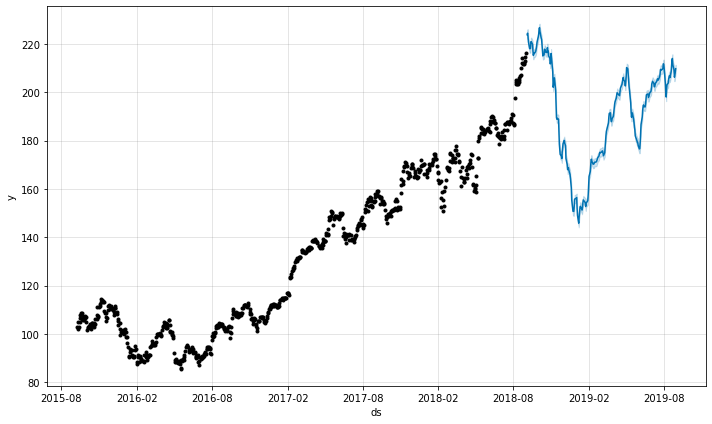

In [104]:
fig1 = m3.plot(forecast3)

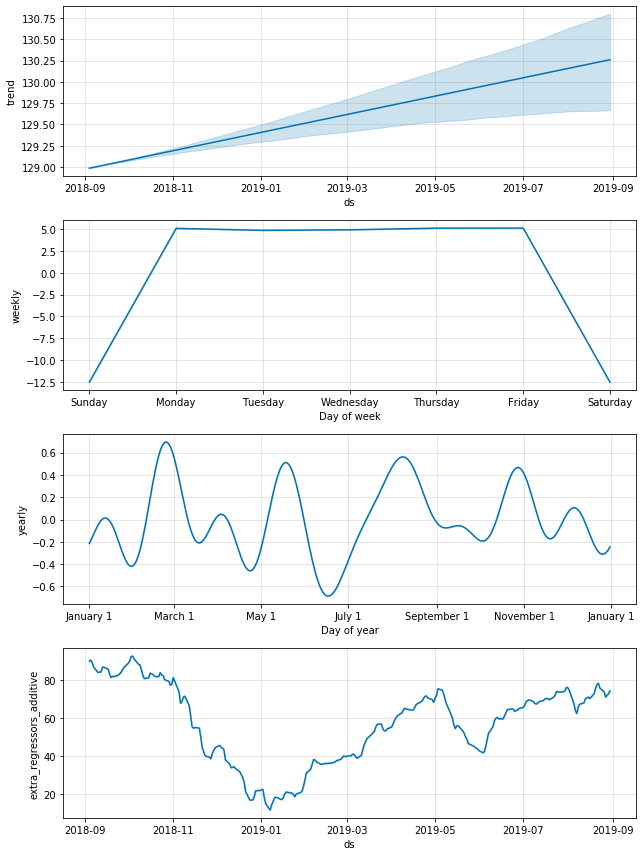

In [105]:
fig2 = m3.plot_components(forecast3)

### Evaluating the model

In [106]:
# Append the forecasted data to the test data
y3_test['yhat'] = forecast3['yhat']
y3_test.tail()

,ds,y,3_day_MA,yhat
245,2019-08-26,206.490005,207.196670,209.216024
246,2019-08-27,204.160004,204.430003,206.212164
247,2019-08-28,205.529999,205.393336,207.205358
248,2019-08-29,209.009995,206.233333,208.209047
249,2019-08-30,208.740005,207.760000,209.708809


In [107]:
# Calculate R-squared value
r2_score(y3_test['y'], y3_test['yhat'])

0.9780932303799027

In [108]:
# Calculate MSE
mean_squared_error(y3_test['y'], y3_test['yhat'])

9.649864067329283

In [109]:
# Calculate MAE
mean_absolute_error(y3_test['y'], y3_test['yhat'])

2.305081128040042

### Iteration 3 Conclusion:

From this iteration, we see that the 3-day Moving Average significantly boosted the model's performance. The general trend of the prediction follows that of the actual values. Furthermore, the indicators performed very well in this iteration. It appears that the Prophet model does indeed work better when combined with analyst knowledge.

## Overall Conclusion

Through this 3 iterations, we notice that the analyst in the loop approach is very effective for such problems. Solely using statistical inference to predict Apple's stock price is ineffectively as there may be external factors affecting the price. However, when paired with feedback from the analyst, such as adding the 3 day moving average indicator, the performance of the model greatly improves.

Besides adding regressors, there are many other parameters which an analyst can use to finetune the model. However, for the scope of this project, I will use iteration 3 as the benchmark against the other models. Overall, the Prophet model has delivered positive results and is a very promising model for such problems.